# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


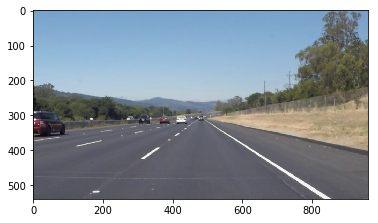

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

**Note: `draw_lines` is the original function given that draws the line segments. `draw_lines_extrapolate` function draws the extrapolated lines. `hough_lines_segments` is the original function given for hough transform which uses `draw_lines`. `hough_lines_extrapolate` uses `draw_lines_extrapolate`.**

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines_extrapolate(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws extrapolated lines on the input image img,
    given lines detected by Hough transform.
    """
    x_right=[]
    y_right=[]
    x_left=[]
    y_left=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # calculate slope of the line segment
            slope = ((y2-y1)/(x2-x1))
            # eliminiate horizontal segments
            if abs(slope) > 0.1:
                if slope >= 0: # right line
                    # only take segments that are on the right
                    if x1 > 440 and x2 > 440:
                        x_right.extend((x1, x2))
                        y_right.extend((y1, y2))
                else: # left line
                    # only take segments that are on the left
                    if x1 < 500 and x2 < 500:
                        x_left.extend((x1, x2))
                        y_left.extend((y1, y2))
    
    # linear fit the segments on the left and the segments on the right, respectively
    [m_left, b_left] = np.polyfit(x_left, y_left, 1)
    [m_right, b_right] = np.polyfit(x_right, y_right, 1)
    # assign maximum and minimum y values
    y_max_int=539
    y_min_int=330
    # calculate the correspond x values
    x_min_left = (y_min_int-b_left)/m_left
    x_max_left = (y_max_int-b_left)/m_left
    x_min_right = (y_min_int-b_right)/m_right
    x_max_right = (y_max_int-b_right)/m_right
    # turn x values into integers, as cv2.line takes (int, int)
    xL_min = int(x_min_left)
    xL_max = int(x_max_left)
    xR_min = int(x_min_right)
    xR_max = int(x_max_right)
    
    # draw the extrapolated lines
    cv2.line(img, (xL_min, y_min_int), (xL_max, y_max_int), color, thickness)
    cv2.line(img, (xR_min, y_min_int), (xR_max, y_max_int), color, thickness)

def hough_lines_extrapolate(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with the extrapolated hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_extrapolate(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[0, 0, 255], thickness=5):
    """
    This is the original draw_lines function given.
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_segments(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
mkdir test_images_output

**I tried different parameter combinations on images and videos and have decided the following pipelines work the best. I mainly changed the shape and location of the mask, `low_threshold`, `high_threshold`, `min_line_length`, and `max_line_gap`. Most of the time, images are easy to process but videos are harder. Therefore, the parameters are mainly decided based on the videos. Later, I will show you the test pipeline I used to debug my video processing. **

In [12]:
# pipeline definition
def pipeline_segments(image):
    """
    This pipeline takes an image input and annotates it with the line segments detected.
    """
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50 
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(440, 325), (530, 325), (910,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 22 #minimum number of pixels making up a line
    max_line_gap = 14   # maximum gap in pixels between connectable line segments
    line_image_segments = hough_lines_segments(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_edges_segments=weighted_img(line_image_segments, image)

    return initial_edges_segments

def pipeline_extrapolate(image):
    """
    This pipeline takes an image input and annotates it with the extrapolated lines detected.
    """
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50 
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(440, 325), (530, 325), (910,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 22 #minimum number of pixels making up a line
    max_line_gap = 14   # maximum gap in pixels between connectable line segments
    line_image_extrapolate = hough_lines_extrapolate(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_edges_extrapolate=weighted_img(line_image_extrapolate, image)

    return initial_edges_extrapolate

**A detailed example of how pipeline works.**

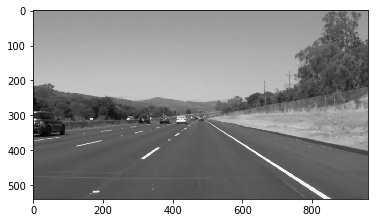

In [49]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = grayscale(image)
plt.imshow(gray, cmap='gray')
plt.savefig('test_images_output/grayscale.jpg')

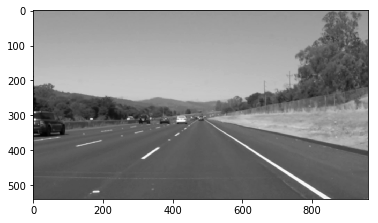

In [50]:
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)
plt.imshow(blur_gray, cmap='gray')
plt.savefig('test_images_output/gaussian-blur.jpg')

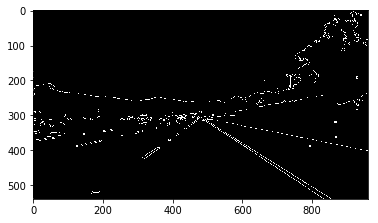

In [53]:
low_threshold = 50 
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.savefig('test_images_output/canny.jpg')

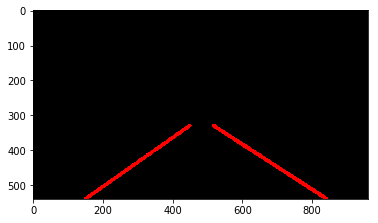

In [57]:
imshape = image.shape
vertices = np.array([[(100,imshape[0]),(440, 325), (530, 325), (910,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 22 #minimum number of pixels making up a line
max_line_gap = 14   # maximum gap in pixels between connectable line segments
line_image_extrapolate = hough_lines_extrapolate(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(line_image_extrapolate)
plt.savefig('test_images_output/hough_extrapolated.jpg')

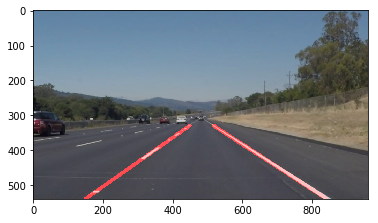

In [58]:
initial_edges_extrapolate=weighted_img(line_image_extrapolate, image)
plt.imshow(initial_edges_extrapolate)

**Test pipelines on all images**

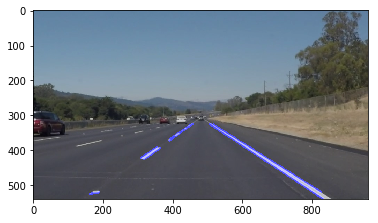

In [13]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_output=pipeline_segments(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidWhiteRight_segments.jpg')

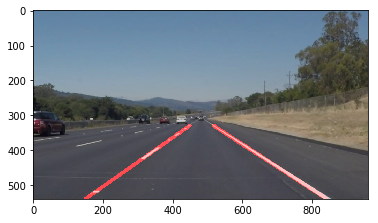

In [14]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_output=pipeline_extrapolate(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidWhiteRight_extrapolate.jpg')

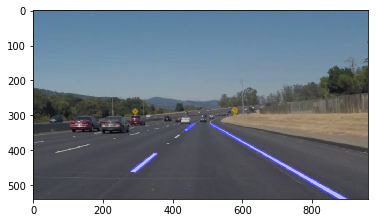

In [15]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image_output=pipeline_segments(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidWhiteCurve_segments.jpg')

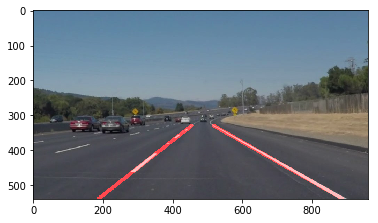

In [16]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image_output=pipeline_extrapolate(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidWhiteCurve_extrapolate.jpg')

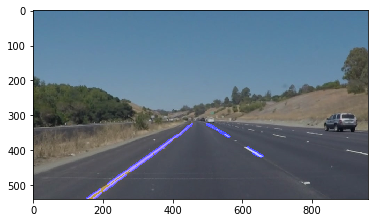

In [17]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image_output=pipeline_segments(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidYellowCurve_segments.jpg')

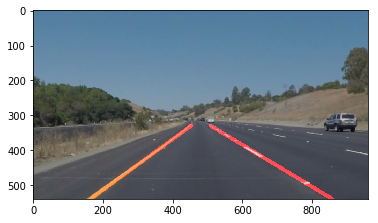

In [18]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image_output=pipeline_extrapolate(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidYellowCurve_extrapolate.jpg')

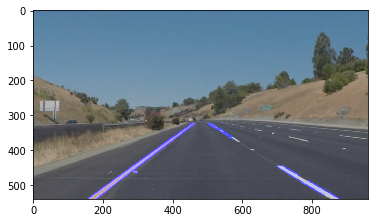

In [19]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_output=pipeline_segments(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidYellowCurve2_segments.jpg')

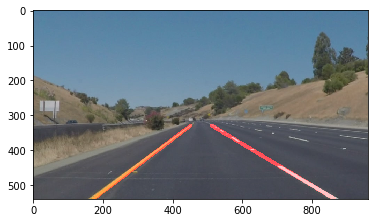

In [20]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image_output=pipeline_extrapolate(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidYellowCurve2_extrapolate.jpg')

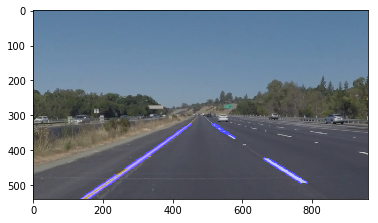

In [21]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image_output=pipeline_segments(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidYellowLeft_segments.jpg')

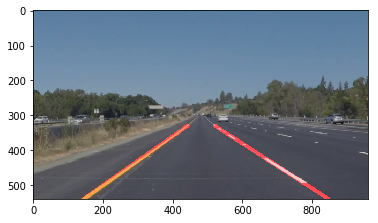

In [22]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image_output=pipeline_extrapolate(image)
plt.imshow(image_output)
plt.savefig('test_images_output/solidYellowLeft_extrapolate.jpg')

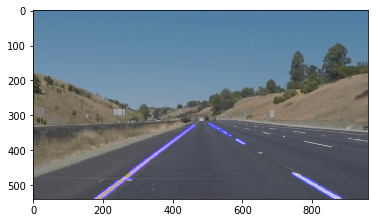

In [23]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image_output=pipeline_segments(image)
plt.imshow(image_output)
plt.savefig('test_images_output/whiteCarLaneSwitch_segments.jpg')

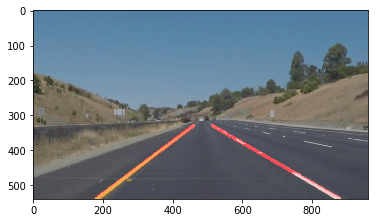

In [24]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image_output=pipeline_extrapolate(image)
plt.imshow(image_output)
plt.savefig('test_images_output/whiteCarLaneSwitch_extrapolate.jpg')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

** The pipelines below have the same parameters as the pipelines above. This is because I tuned parameters based on video performance.**

In [26]:
def process_image_segments(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    """
    This pipeline returns the annotated image with detected line segments.
    """
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50 
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(440, 325), (530, 325), (910,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 22 #minimum number of pixels making up a line
    max_line_gap = 14   # maximum gap in pixels between connectable line segments
    line_image_segments = hough_lines_segments(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_edges_segments=weighted_img(line_image_segments, image)
    # you should return the final output (image where lines are drawn on lanes)

    return initial_edges_segments

def process_image_extrapolate(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    """
    This pipeline returns the annotated image with detected and extrapolated lines.
    """
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50 
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(440, 325), (530, 325), (910,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 22 #minimum number of pixels making up a line
    max_line_gap = 14   # maximum gap in pixels between connectable line segments
    line_image_extrapolate = hough_lines_extrapolate(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_edges_extrapolate=weighted_img(line_image_extrapolate, image)
    # you should return the final output (image where lines are drawn on lanes)

    return initial_edges_extrapolate

Let's try the one with the solid white lane on the right first ...

In [27]:
mkdir test_videos_output

mkdir: cannot create directory ‘test_videos_output’: File exists


**Test on solidWhiteRight.mp4 first.**

First, annotate it with line segments.

In [28]:
white_output = 'test_videos_output/solidWhiteRight_segments.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_segments) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_segments.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_segments.mp4


100%|█████████▉| 221/222 [00:03<00:00, 52.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_segments.mp4 

CPU times: user 8.96 s, sys: 85.9 ms, total: 9.05 s
Wall time: 4.02 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Second, annotate it with extrapolated lines.

In [30]:
white_output = 'test_videos_output/solidWhiteRight_extrapolate.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_extrapolate) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_extrapolate.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_extrapolate.mp4


100%|█████████▉| 221/222 [00:03<00:00, 56.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_extrapolate.mp4 

CPU times: user 8.93 s, sys: 72.5 ms, total: 9 s
Wall time: 4.24 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

---
**The `draw_lines` function has already been improved, as defined in `draw_lines_extrapolate`.**

---

Now for the one with the solid yellow lane on the left. This one's more tricky!

**Now test on solidYellowLeft.mp4.**

First, annotate it with line segments.

In [32]:
yellow_output = 'test_videos_output/solidYellowLeft_segments.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_segments)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_segments.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_segments.mp4


100%|█████████▉| 681/682 [00:12<00:00, 56.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_segments.mp4 

CPU times: user 28.2 s, sys: 225 ms, total: 28.4 s
Wall time: 12.4 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [34]:
yellow_output = 'test_videos_output/solidYellowLeft_extrapolate.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_extrapolate)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_extrapolate.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_extrapolate.mp4


100%|█████████▉| 681/682 [00:12<00:00, 56.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_extrapolate.mp4 

CPU times: user 28.1 s, sys: 242 ms, total: 28.4 s
Wall time: 12.3 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Test Code for Debugging and Parameter Tuning

Here is the pipeline I used to debug and tune parameters.

In [36]:
def draw_lines_test(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function annotates the input image with:
    1. The masked region - yellow lines
    2. The line segments accepted and assigned to each side. Green for right, and cyan for left.
    Linear regression is performed on these segments to extrapolate the lines.
    3. The extrapolated lines. Blue for right and red for left.
    """
    x_right=[]
    y_right=[]
    x_left=[]
    y_left=[]
    imshape = img.shape
    cv2.line(img, (100,imshape[0]), (440, 325), [255,255,0], 3)
    cv2.line(img, (440, 325), (530, 325), [255,255,0], 3)
    cv2.line(img, (530, 325), (910,imshape[0]), [255,255,0], 3)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            if abs(slope) > 0.1:
                if slope >= 0: # right line
                    if x1 > 440 and x2 > 440:
                        x_right.extend((x1, x2))
                        y_right.extend((y1, y2))
                        # if accepted, plot the segment.
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 5)
                else: # left line
                    if x1 < 500 and x2 < 500:
                        x_left.extend((x1, x2))
                        y_left.extend((y1, y2))
                        # if accepted, plot the segment.
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,255], 5)
    
    [m_left, b_left] = np.polyfit(x_left, y_left, 1)
    [m_right, b_right] = np.polyfit(x_right, y_right, 1)
    y_max_int=539
    y_min_int=330
    x_min_left = (y_min_int-b_left)/m_left
    x_max_left = (y_max_int-b_left)/m_left
    x_min_right = (y_min_int-b_right)/m_right
    x_max_right = (y_max_int-b_right)/m_right
    xL_min = int(x_min_left)
    xL_max = int(x_max_left)
    xR_min = int(x_min_right)
    xR_max = int(x_max_right)
    
    # plot the extrapolated lines.
    cv2.line(img, (xL_min, y_min_int), (xL_max, y_max_int), [255,0,0], 3)
    cv2.line(img, (xR_min, y_min_int), (xR_max, y_max_int), [0,0,255], 3)

def hough_lines_test(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_test(line_img, lines)
    return line_img

In [37]:
def process_image_test(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50 
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(440, 325), (530, 325), (910,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 22 #minimum number of pixels making up a line
    max_line_gap = 14   # maximum gap in pixels between connectable line segments
    line_image_test = hough_lines_test(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_edges_test=weighted_img(line_image_test, image)
    # you should return the final output (image where lines are drawn on lanes)

    return initial_edges_test

Test on solidWhiteRight.mp4

In [38]:
white_output = 'test_videos_output/solidWhiteRight_test.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_test) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_test.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_test.mp4


100%|█████████▉| 221/222 [00:03<00:00, 59.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_test.mp4 

CPU times: user 9.08 s, sys: 63.5 ms, total: 9.14 s
Wall time: 4 s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Test on solidYellowLeft.mp4

In [40]:
yellow_output = 'test_videos_output/solidYellowLeft_test.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_test)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_test.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_test.mp4


100%|█████████▉| 681/682 [00:12<00:00, 55.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_test.mp4 

CPU times: user 28.8 s, sys: 280 ms, total: 29.1 s
Wall time: 12.6 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

**Here is my attempt on the challenge.**

I adjusted the region of interest and tried color profile conversion to make the lines more recognizable. I am still having problem with supressing the shadows, but for now I will leave my attempt as it is.

In [42]:
def draw_lines_challenge_test(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function annotates the input image with:
    1. The masked region - yellow lines
    2. The line segments accepted and assigned to each side. Green for right, and cyan for left.
    Linear regression is performed on these segments to extrapolate the lines.
    3. The extrapolated lines. Blue for right and red for left.
    """
    
    x_right=[]
    y_right=[]
    x_left=[]
    y_left=[]
    cv2.line(img, (250,650), (580, 460), [255,255,0], 3)
    cv2.line(img, (580, 460), (750, 460), [255,255,0], 3)
    cv2.line(img, (750, 460), (1100,650), [255,255,0], 3)
    cv2.line(img, (250,650), (1100,650), [255,255,0], 3)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1)) # note that y increases from top to bottom
            if abs(slope) > 0.3:
                if slope >= 0: # right line
                    if x1 > 580 and x2 > 580:
                        x_right.extend((x1, x2))
                        y_right.extend((y1, y2))
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 5)
                else: # left line
                    if x1 < 750 and x2 < 750:
                        x_left.extend((x1, x2))
                        y_left.extend((y1, y2))
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,255], 5)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    [m_left, b_left] = np.polyfit(x_left, y_left, 1)
    [m_right, b_right] = np.polyfit(x_right, y_right, 1)
    y_max_int=650
    y_min_int=460
    x_min_left = (y_min_int-b_left)/m_left
    x_max_left = (y_max_int-b_left)/m_left
    x_min_right = (y_min_int-b_right)/m_right
    x_max_right = (y_max_int-b_right)/m_right
    xL_min = int(x_min_left)
    xL_max = int(x_max_left)
    xR_min = int(x_min_right)
    xR_max = int(x_max_right)
    
    cv2.line(img, (xL_min, y_min_int), (xL_max, y_max_int), [255,0,0], 3)
    cv2.line(img, (xR_min, y_min_int), (xR_max, y_max_int), [0,0,255], 3)

def hough_lines_challenge_test(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_challenge_test(line_img, lines)
    return line_img

In [43]:
def process_image_challenge_test(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    #gray = grayscale(image)
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v=hsv[:,:,2]
    #gray = grayscale(v)
    kernel_size = 5
    blur_gray = gaussian_blur(v, kernel_size)
    low_threshold = 50 
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(250,650),(580, 460), (750, 460), (1100, 650)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 22 #minimum number of pixels making up a line
    max_line_gap = 8   # maximum gap in pixels between connectable line segments
    line_image_test = hough_lines_challenge_test(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_edges_test=weighted_img(line_image_test, image)
    # you should return the final output (image where lines are drawn on lanes)

    return initial_edges_test

In [44]:
challenge_output = 'test_videos_output/challenge_test.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge_test)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_test.mp4
[MoviePy] Writing video test_videos_output/challenge_test.mp4


100%|██████████| 251/251 [00:07<00:00, 33.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_test.mp4 

CPU times: user 13.9 s, sys: 163 ms, total: 14 s
Wall time: 7.89 s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

It is clear from the above test videos that shadow suppression is the key to avoid confusion.